In [1]:
import scanpy as sc 
import scvi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import snapatac2 as snap
import seaborn as sns
import os

In [2]:
%%time
peak_mat = sc.read_h5ad("06C_peak_matrix_with_new_UMAP.h5ad")
peak_mat

CPU times: user 4.05 s, sys: 25.3 s, total: 29.4 s
Wall time: 29.3 s


AnnData object with n_obs × n_vars = 690956 × 654221
    obs: 'ATAC_barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse', 'cell_type', 'tech_plus_study'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'

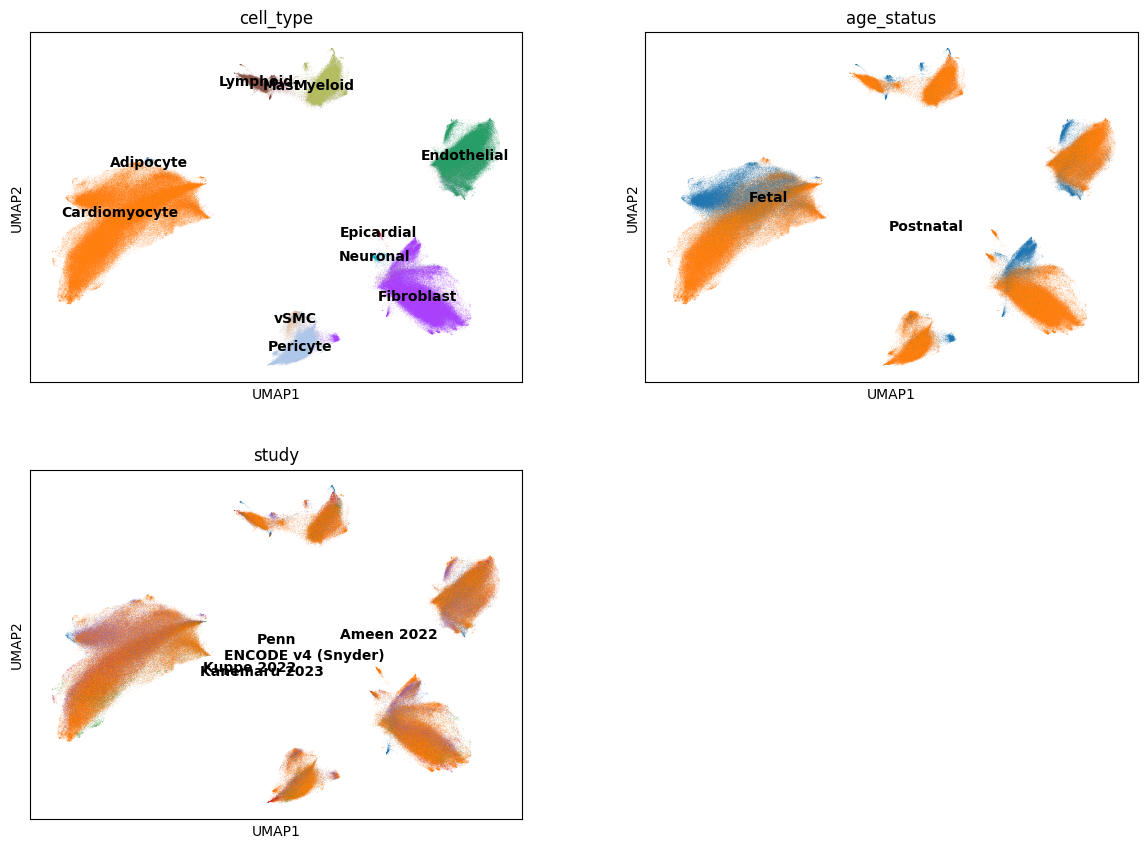

CPU times: user 8.65 s, sys: 370 ms, total: 9.02 s
Wall time: 8.84 s


In [3]:
%%time
sc.pl.umap(peak_mat, color = ["cell_type", "age_status", "study"], legend_loc = "on data", ncols = 2)

### Reannotate the fibroblast cluster near pericytes as fetal pericytes

In [4]:
def add_umap_coords(adata):
    '''Add UMAP1 and UMAP2 to the obs DataFrame for easier manipulation, as scanpy does not show coordinates'''
    umap_coords = adata.obsm["X_umap"]
    adata.obs["UMAP1"] = umap_coords[:, 0]
    adata.obs["UMAP2"] = umap_coords[:, 1]
    return(adata)

In [5]:
%%time
Fibroblast_adata = peak_mat[peak_mat.obs.cell_type == "Fibroblast"].copy()
Fibroblast_adata

CPU times: user 4.16 s, sys: 19.7 s, total: 23.9 s
Wall time: 23.9 s


AnnData object with n_obs × n_vars = 143128 × 654221
    obs: 'ATAC_barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse', 'cell_type', 'tech_plus_study'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'cell_type_colors', 'age_status_colors', 'study_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'

In [6]:
%%time
Fibroblast_adata = add_umap_coords(Fibroblast_adata)

CPU times: user 864 μs, sys: 1.91 ms, total: 2.77 ms
Wall time: 1.92 ms


<Axes: xlabel='UMAP1', ylabel='UMAP2'>

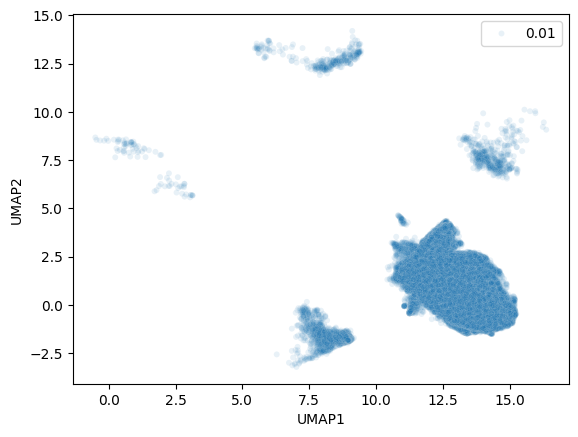

In [7]:
sns.scatterplot(data = Fibroblast_adata.obs, x = 'UMAP1', y = 'UMAP2', size = 0.01, alpha = 0.1)

In [8]:
%%time
filt_Fibroblast_adata = ( Fibroblast_adata[(Fibroblast_adata.obs.UMAP1 > 9.5) & (Fibroblast_adata.obs.UMAP2 < 5.0)] ).copy()

CPU times: user 1.72 s, sys: 7.85 s, total: 9.56 s
Wall time: 9.62 s


In [9]:
Fetal_Pericyte_adata = ( Fibroblast_adata[(Fibroblast_adata.obs.UMAP1 < 9.5) & (Fibroblast_adata.obs.UMAP2 < 1.0)] ).copy()
Fetal_Pericyte_adata

AnnData object with n_obs × n_vars = 2979 × 654221
    obs: 'ATAC_barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse', 'cell_type', 'tech_plus_study', 'UMAP1', 'UMAP2'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'cell_type_colors', 'age_status_colors', 'study_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'

In [10]:
dropped_Fibroblast_indices = set(Fibroblast_adata.obs_names) - set(filt_Fibroblast_adata.obs_names) - set(Fetal_Pericyte_adata.obs_names)

In [11]:
%%time
filt_peak_mat = peak_mat[~peak_mat.obs_names.isin(dropped_Fibroblast_indices)].copy()
filt_peak_mat

CPU times: user 28.1 s, sys: 2min 6s, total: 2min 34s
Wall time: 2min 34s


AnnData object with n_obs × n_vars = 690044 × 654221
    obs: 'ATAC_barcode', 'sample_id', 'leiden', 'donor_id', 'study', 'age_status', 'age', 'sex', 'region', 'disease_binary', 'technology', 'fragment_file', 'full_path', 'file', 'nfrag', 'tsse', 'cell_type', 'tech_plus_study'
    var: 'count', 'selected'
    uns: 'spectral_eigenvalue', 'cell_type_colors', 'age_status_colors', 'study_colors'
    obsm: 'X_spectral', 'X_spectral_harmony', 'X_umap'

In [12]:
# change the annotation of the fetal pericytes to Pericyte
filt_peak_mat.obs.loc[filt_peak_mat.obs_names.isin(Fetal_Pericyte_adata.obs_names), 'cell_type'] = "Pericyte"

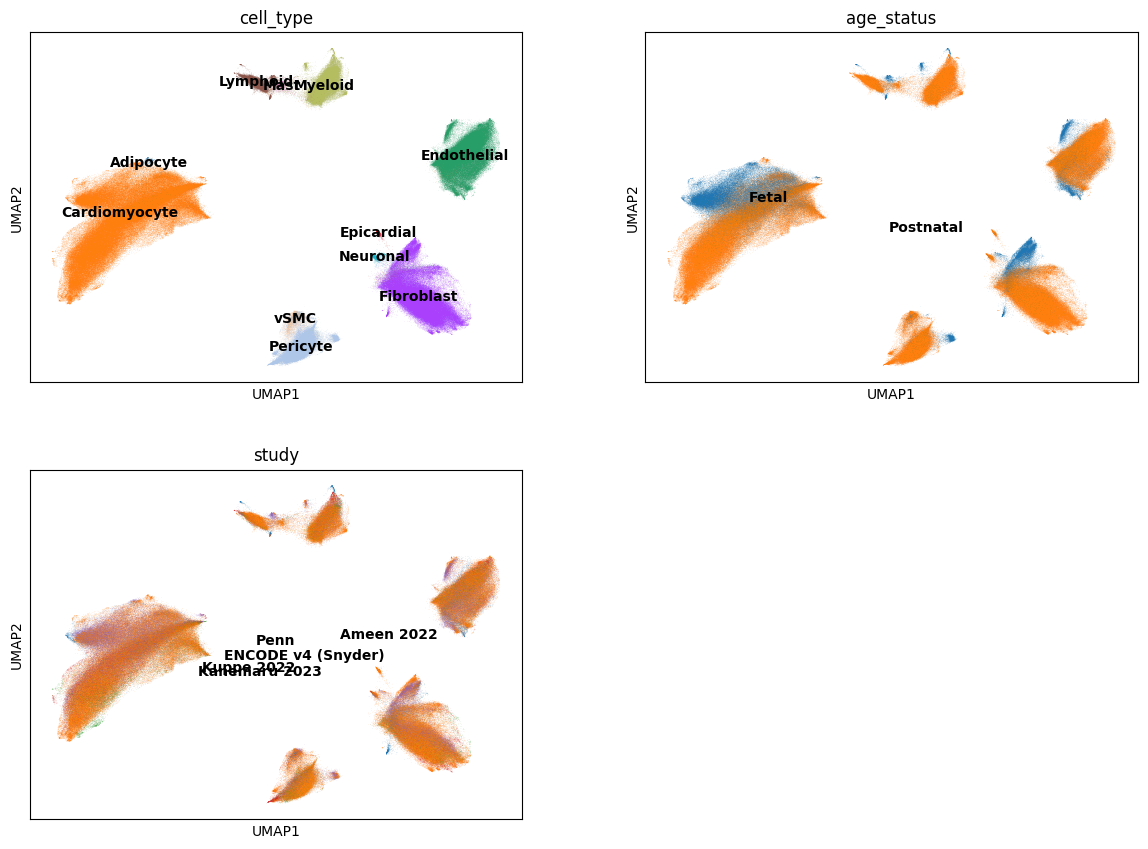

In [13]:
sc.pl.umap(filt_peak_mat, color = ["cell_type", "age_status", "study"], legend_loc = "on data", ncols = 2)

### Also perform leiden clustering

In [14]:
%%time
# Perform leiden clustering
sc.pp.neighbors(filt_peak_mat, use_rep="X_spectral_harmony", metric="cosine")
sc.tl.leiden(filt_peak_mat, resolution=0.5, n_iterations = 2, flavor="igraph")

CPU times: user 5min 16s, sys: 20.6 s, total: 5min 37s
Wall time: 5min 22s


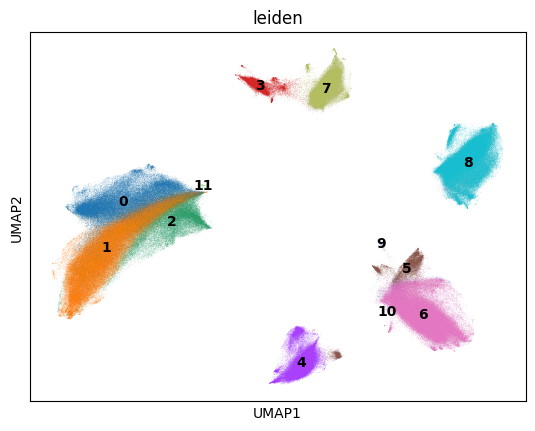

In [15]:
sc.pl.umap(filt_peak_mat, color = "leiden", legend_loc = "on data")

### Obtain marker genes using SnapATAC2

In [16]:
%%time
marker_peaks = snap.tl.marker_regions(filt_peak_mat, groupby='cell_type', pvalue=0.01)

CPU times: user 15min 10s, sys: 48.6 s, total: 15min 59s
Wall time: 15min 59s


### Save the filtered peak matrix

In [17]:
%%time
filt_peak_mat.write("06D_filtered_peak_matrix.h5ad")

CPU times: user 7.82 s, sys: 25.9 s, total: 33.7 s
Wall time: 37.6 s


### Save the marker peaks for each cell type

In [18]:
cell_types = filt_peak_mat.obs.cell_type.unique()

marker_peaks_dir = "marker_peaks_per_cell_type/"
os.makedirs(marker_peaks_dir, exist_ok=True)

In [19]:
def extract_genome_coordinates(peak_df, column_name):
    '''Convert a column of a pandas df that is of the format (chr:start-end) to three different columns, 
    called chr, start, and end. Specify the column_name for original column.'''

    peak_df[["chr", "coords"]] =  peak_df[column_name].str.split(":", expand=True)
    peak_df[["start", "end"]] = peak_df["coords"].str.split("-", expand=True)
    peak_df = peak_df.drop(columns=["coords"])

    return peak_df

### Identify the number of differential peaks per cell type

In [20]:
num_diff_peaks = list()

for cell_type in cell_types:
    marker_peaks_df = marker_peaks[cell_type].to_frame()
    
    # extract the coordinates in a bed-like format, and save the output
    marker_peaks_df = extract_genome_coordinates(marker_peaks_df, 0)
    marker_peaks_df = marker_peaks_df.drop(columns = 0)
    marker_peaks_df.to_csv(marker_peaks_dir + cell_type + "_marker_peaks.csv")

    # append the number of differential peaks
    num_diff_peaks.append(marker_peaks_df.shape[0])

In [21]:
marker_peaks_per_cell_type = pd.DataFrame({'cell_type': cell_types,
             'diff_peaks': num_diff_peaks})

In [22]:
marker_peaks_per_cell_type

,cell_type,diff_peaks
0,Adipocyte,44727
1,Cardiomyocyte,35398
2,Endothelial,14386
3,Epicardial,22292
4,Fibroblast,15737
5,Pericyte,7058
6,Myeloid,25555
7,Lymphoid,13083
8,Mast,17560
9,Neuronal,16518


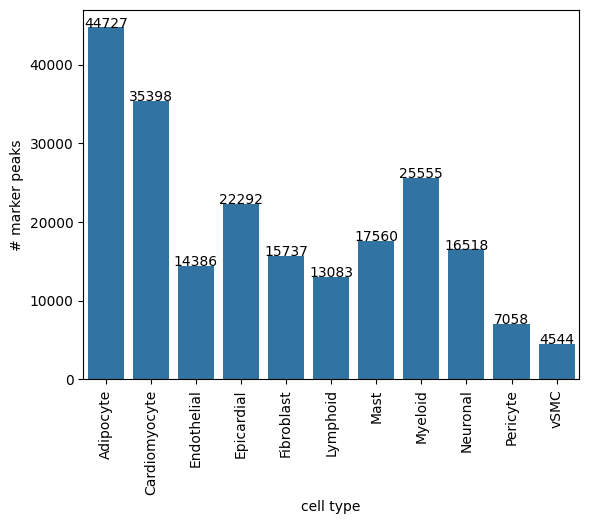

In [23]:
ax = sns.barplot(data=marker_peaks_per_cell_type, x='cell_type', y='diff_peaks')

plt.xticks(rotation = 90)
plt.xlabel("cell type")
plt.ylabel("# marker peaks")

# add the values above the bar plot
for bar in ax.patches:  
    x = bar.get_x() + bar.get_width() / 2  # center the value
    y = bar.get_height()  
    plt.text(x=x, 
             y=y + 1, 
             s=f'{y:.0f}', 
             ha='center', 
             fontsize=10)
plt.savefig("../../paper_figures/snATAC_marker_peaks_per_cell_type.pdf")
plt.show()